In [16]:
using Oceananigans
using Oceananigans.Units
using GLMakie
using JLD2
using NCDatasets

In [17]:
using Oceananigans: architecture

In [18]:
using DelimitedFiles, FileIO

In [19]:
using ClimaOcean

In [20]:
using Oceananigans.Operators: ℑxyᶠᶜᵃ, ℑxyᶜᶠᵃ
using Oceananigans.Operators: Δzᵃᵃᶜ

In [21]:
using Statistics
using JLD2
using Printf
using SeawaterPolynomials.TEOS10: TEOS10EquationOfState
using CUDA: @allowscalar

In [48]:
using SeawaterPolynomials.TEOS10

In [7]:
arch = CPU()

CPU()

In [8]:
save_interval = 5minutes

300.0

# Grid

In [82]:
# z_levels = stretched_vertical_faces(depth = 300, 
#                              surface_layer_Δz = 2.5, 
#                              stretching = PowerLawStretching(1.090), 
#                              surface_layer_height = 30)
z_levels = -reverse([0.5, 1, 2, 3, 4, 6, 8, 9, 10, 12, 16, 20, 30, 50, 100, 150, 200, 250, 275])

19-element Vector{Float64}:
 -275.0
 -250.0
 -200.0
 -150.0
 -100.0
  -50.0
  -30.0
  -20.0
  -16.0
  -12.0
  -10.0
   -9.0
   -8.0
   -6.0
   -4.0
   -3.0
   -2.0
   -1.0
   -0.5

In [83]:
writedlm( "z-grid_Tyr.csv",  z_levels, ',')

In [84]:
Nx = 43
Ny = 54
Nz = length(z_levels)-1

18

In [85]:
underlying_grid = RectilinearGrid(topology=(Bounded, Bounded, Bounded), size=(Nx, Ny, Nz),
                                        x = (0, 500*Nx), y = (0, 500*Ny),
                                        z = z_levels, halo=(7,7,7))

43×54×18 RectilinearGrid{Float64, Bounded, Bounded, Bounded} on CPU with 7×7×7 halo
├── Bounded  x ∈ [0.0, 21500.0] regularly spaced with Δx=500.0
├── Bounded  y ∈ [0.0, 27000.0] regularly spaced with Δy=500.0
└── Bounded  z ∈ [-275.0, -0.5] variably spaced with min(Δz)=0.5, max(Δz)=50.0

In [86]:
@load "bathymetry_Tyrifjord.jld2" depth

1-element Vector{Symbol}:
 :depth

In [87]:
depth

43×54 Matrix{Float64}:
 0.0    0.0       0.0       0.0     …   0.0       0.0      0.0  0.0
 0.0    0.0       0.0       0.0         0.0       0.0      0.0  0.0
 0.0    0.0       0.0       0.0         0.0       0.0      0.0  0.0
 0.0    0.0       0.0       0.0         0.0       0.0      0.0  0.0
 0.0    0.0       0.0       0.0         0.0       0.0      0.0  0.0
 0.0    0.0       0.0       0.0     …   0.0       0.0      0.0  0.0
 0.0    0.0       0.0       0.0         0.0       0.0      0.0  0.0
 0.0    0.0       0.0       0.0         0.0       0.0      0.0  0.0
 0.0    0.0       0.0       0.0         0.0       0.0      0.0  0.0
 0.0    0.0       0.0       0.0         0.0       0.0      0.0  0.0
 0.0    0.0       0.0       0.0     …   0.0       0.0      0.0  0.0
 0.0    0.0       0.0       0.0         0.0       0.0      0.0  0.0
 0.0    0.0       0.0       0.0         0.0       0.0      0.0  0.0
 ⋮                                  ⋱   ⋮                       
 0.0    0.0       0.0       

In [88]:
grid = ImmersedBoundaryGrid(underlying_grid, GridFittedBottom(depth); active_cells_map = true)

43×54×18 ImmersedBoundaryGrid{Float64, Bounded, Bounded, Bounded} on CPU with 7×7×7 halo:
├── immersed_boundary: GridFittedBottom(mean(z)=-20.6841, min(z)=-202.905, max(z)=0.0)
├── underlying_grid: 43×54×18 RectilinearGrid{Float64, Bounded, Bounded, Bounded} on CPU with 7×7×7 halo
├── Bounded  x ∈ [0.0, 21500.0] regularly spaced with Δx=500.0
├── Bounded  y ∈ [0.0, 27000.0] regularly spaced with Δy=500.0
└── Bounded  z ∈ [-275.0, -0.5] variably spaced with min(Δz)=0.5, max(Δz)=50.0

# Physics

In [89]:
const surface_νz = 1e-2
const background_νz = 1e-4
const background_κz = 1e-5

@inline νz(x, y, z, t) = ifelse(z > -30, surface_νz, background_νz)

horizontal_viscosity = HorizontalScalarDiffusivity(ν=1e3)
vertical_viscosity   = VerticalScalarDiffusivity(VerticallyImplicitTimeDiscretization(),
                                                 ν=νz, κ=background_κz)
convective_adjustment = ConvectiveAdjustmentVerticalDiffusivity(convective_κz=0.1)
κ_skew = 900.0      # [m² s⁻¹] skew diffusivity
κ_symmetric = 900.0 # [m² s⁻¹] symmetric diffusivity

gent_mcwilliams_diffusivity = IsopycnalSkewSymmetricDiffusivity(; κ_skew, κ_symmetric,
                                                                slope_limiter = FluxTapering(1e-2))

    
closure = (
    vertical_viscosity,
    horizontal_viscosity,
    convective_adjustment,
    gent_mcwilliams_diffusivity,
)

(VerticalScalarDiffusivity{VerticallyImplicitTimeDiscretization}(ν=νz (generic function with 1 method), κ=1.0e-5), HorizontalScalarDiffusivity{ExplicitTimeDiscretization}(ν=1000.0, κ=0.0), ConvectiveAdjustmentVerticalDiffusivity{VerticallyImplicitTimeDiscretization}(background_κz=0.0 convective_κz=0.1 background_νz=0.0 convective_νz=0.0), IsopycnalSkewSymmetricDiffusivity: (κ_symmetric=900.0, κ_skew=900.0, (isopycnal_tensor=Oceananigans.TurbulenceClosures.SmallSlopeIsopycnalTensor{Float64}(0.0), slope_limiter=FluxTapering{Float64}(0.01)))

In [91]:
eos = TEOS10EquationOfState()
buoyancy = SeawaterBuoyancy(equation_of_state=eos)

SeawaterBuoyancy{Float64}:
├── gravitational_acceleration: 9.80665
└── equation_of_state: BoussinesqEquationOfState{Float64}

# Boundary conditions (u, v, T, S)

In [92]:
reference_density        = 1000.0
reference_heat_capacity  = 3991.0
reference_salinity       = 0

0

In [93]:
# Files contain 12 arrays of monthly-averaged data from 1992
@info "Reading boundary conditions..."; start=time_ns()
boundary_conditions_file = jldopen("surface_boundary_conditions_360_150_75S_75N.jld2")
τˣ = - boundary_conditions_file["τˣ"] ./ reference_density
τʸ = - boundary_conditions_file["τʸ"] ./ reference_density
T★ = + boundary_conditions_file["Tₛ"]
S★ = + boundary_conditions_file["Sₛ"]
Q★ = - boundary_conditions_file["Qᶠ"] ./ reference_density ./ reference_heat_capacity
F★ = - boundary_conditions_file["Sᶠ"] ./ reference_density .* reference_salinity
close(boundary_conditions_file)

[ Info: Reading boundary conditions...
┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 C:\Users\ABE\.julia\packages\JLD2\VWinU\src\JLD2.jl:300


LoadError: SystemError: opening file "surface_boundary_conditions_360_150_75S_75N.jld2": No such file or directory

In [ ]:
# Convert boundary conditions arrays to GPU (CPU here)
τˣ = on_architecture(arch, τˣ)
τʸ = on_architecture(arch, τʸ)
target_sea_surface_temperature = T★ = on_architecture(arch, T★)
target_sea_surface_salinity = S★ = on_architecture(arch, S★)
surface_temperature_flux = Q★ = on_architecture(arch, Q★)
surface_salt_flux = F★ = on_architecture(arch, F★)

In [254]:
τˣ = 0.01  #[0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075]
τʸ = -0.008  #[0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.115]
target_sea_surface_temperature = T★ = 3
target_sea_surface_salinity = S★ = 0
surface_temperature_flux = Q★ = 0.01
surface_salt_flux = F★ = 0.01

0.01

In [255]:
##### Boundary conditions / time-dependent fluxes 

const Nyears = 2.0
const Nmonths = 12
const thirty_days = 30days

@inline current_time_index(time, tot_months) = mod(unsafe_trunc(Int32, time / thirty_days), tot_months) + 1
@inline next_time_index(time, tot_months) = mod(unsafe_trunc(Int32, time / thirty_days) + 1, tot_months) + 1
@inline cyclic_interpolate(u₁::Number, u₂, time) = u₁ + mod(time / thirty_days, 1) * (u₂ - u₁)

Δz_top = @allowscalar Δzᵃᵃᶜ(1, 1, grid.Nz, grid.underlying_grid)
Δz_bottom = @allowscalar Δzᵃᵃᶜ(1, 1, 1, grid.underlying_grid)

@inline function surface_wind_stress(i, j, grid, clock, fields, τ)
    time = clock.time
    n₁ = current_time_index(time, Nmonths)
    n₂ = next_time_index(time, Nmonths)

    @inbounds begin  # inbounds for faster performance, doesn't check the boundaries of the array
        τ₁ = τ[i, j, n₁]
        τ₂ = τ[i, j, n₂]
    end

    return cyclic_interpolate(τ₁, τ₂, time)
end

Δz_top = @allowscalar grid.Δzᵃᵃᶜ[Nz]

# Linear bottom drag:
μ = 0.003 # Non dimensional

@inline speedᶠᶜᶜ(i, j, k, grid, fields) = @inbounds sqrt(fields.u[i, j, k]^2 + ℑxyᶠᶜᵃ(i, j, k, grid, fields.v)^2)
@inline speedᶜᶠᶜ(i, j, k, grid, fields) = @inbounds sqrt(fields.v[i, j, k]^2 + ℑxyᶜᶠᵃ(i, j, k, grid, fields.u)^2)

@inline u_bottom_drag(i, j, grid, clock, fields, μ) = @inbounds - μ * fields.u[i, j, 1] * speedᶠᶜᶜ(i, j, 1, grid, fields)
@inline v_bottom_drag(i, j, grid, clock, fields, μ) = @inbounds - μ * fields.v[i, j, 1] * speedᶜᶠᶜ(i, j, 1, grid, fields)

@inline u_immersed_bottom_drag(i, j, k, grid, clock, fields, μ) = @inbounds - μ * fields.u[i, j, k] * speedᶠᶜᶜ(i, j, k, grid, fields)
@inline v_immersed_bottom_drag(i, j, k, grid, clock, fields, μ) = @inbounds - μ * fields.v[i, j, k] * speedᶜᶠᶜ(i, j, k, grid, fields)

drag_u = FluxBoundaryCondition(u_immersed_bottom_drag, discrete_form=true, parameters = μ)
drag_v = FluxBoundaryCondition(v_immersed_bottom_drag, discrete_form=true, parameters = μ)

no_slip_bc = ValueBoundaryCondition(0)

u_immersed_bc = ImmersedBoundaryCondition(bottom = drag_u,
                                          west = no_slip_bc,
                                          east = no_slip_bc,
                                          south = no_slip_bc,
                                          north = no_slip_bc)

v_immersed_bc = ImmersedBoundaryCondition(bottom = drag_v,
                                          west = no_slip_bc,
                                          east = no_slip_bc,
                                          south = no_slip_bc,
                                          north = no_slip_bc)

u_bottom_drag_bc = FluxBoundaryCondition(u_bottom_drag, discrete_form = true, parameters = μ)
v_bottom_drag_bc = FluxBoundaryCondition(v_bottom_drag, discrete_form = true, parameters = μ)

u_wind_stress_bc = FluxBoundaryCondition(surface_wind_stress, discrete_form = true, parameters = τˣ);
v_wind_stress_bc = FluxBoundaryCondition(surface_wind_stress, discrete_form = true, parameters = τʸ);

@inline function surface_temperature_relaxation(i, j, grid, clock, fields, p)
    time = clock.time

    n₁ = current_time_index(time, Nmonths)
    n₂ = next_time_index(time, Nmonths)

    @inbounds begin
        T★₁ = p.T★[i, j, n₁]
        T★₂ = p.T★[i, j, n₂]
        Q★₁ = p.Q★[i, j, n₁]
        Q★₂ = p.Q★[i, j, n₂]
        T_surface = fields.T[i, j, grid.Nz]
    end

    T★ = cyclic_interpolate(T★₁, T★₂, time)
    Q★ = cyclic_interpolate(Q★₁, Q★₂, time)

    return Q★ + p.λ * (T_surface - T★)
end


┌ Warning: `ImmersedBoundaryCondition` is experimental.
└ @ Oceananigans.ImmersedBoundaries C:\Users\ABE\.julia\packages\Oceananigans\E4XVr\src\ImmersedBoundaries\immersed_boundary_condition.jl:59
┌ Warning: `ImmersedBoundaryCondition` is experimental.
└ @ Oceananigans.ImmersedBoundaries C:\Users\ABE\.julia\packages\Oceananigans\E4XVr\src\ImmersedBoundaries\immersed_boundary_condition.jl:59


surface_temperature_relaxation (generic function with 1 method)

In [256]:
T_relaxation_parameters = (λ = Δz_top/1days, # Δz_top/30days,
                           T★ = target_sea_surface_temperature,
                           Q★ = surface_temperature_flux)


T_surface_relaxation_bc = FluxBoundaryCondition(surface_temperature_relaxation,
                                                discrete_form = true,
                                                parameters = T_relaxation_parameters)

u_bcs = FieldBoundaryConditions(top = u_wind_stress_bc,
                                bottom = u_bottom_drag_bc,
                                immersed = u_immersed_bc)

v_bcs = FieldBoundaryConditions(top = v_wind_stress_bc,
                                bottom = v_bottom_drag_bc,
                                immersed = v_immersed_bc)

T_bcs = FieldBoundaryConditions(top = T_surface_relaxation_bc)

Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── east: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── south: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── north: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── bottom: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── top: FluxBoundaryCondition: DiscreteBoundaryFunction surface_temperature_relaxation with parameters (λ=5.78704e-6, T★=3, Q★=0.01)
└── immersed: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)

In [257]:
boundary_conditions = (u=u_bcs, v=v_bcs)

(u = Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── east: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── south: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── north: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── bottom: FluxBoundaryCondition: DiscreteBoundaryFunction u_bottom_drag with parameters 0.003
├── top: FluxBoundaryCondition: DiscreteBoundaryFunction surface_wind_stress with parameters 0.01
└── immersed: ImmersedBoundaryCondition with west=Value, east=Value, south=Value, north=Value, bottom=Flux, top=Nothing, v = Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── east: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── south: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── north: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├─

File Nx*Ny with athmospheric forcing

# Model

In [258]:
model = HydrostaticFreeSurfaceModel(; grid,
                                    closure,
                                    buoyancy=BuoyancyTracer(),
                                    boundary_conditions,
                                    momentum_advection = VectorInvariant(), 
                                    tracer_advection = WENO(underlying_grid),
                                    tracers = (:T, :b))

┌ Warning: `ImmersedBoundaryCondition` is experimental.
└ @ Oceananigans.ImmersedBoundaries C:\Users\ABE\.julia\packages\Oceananigans\E4XVr\src\ImmersedBoundaries\immersed_boundary_condition.jl:59
┌ Warning: `ImmersedBoundaryCondition` is experimental.
└ @ Oceananigans.ImmersedBoundaries C:\Users\ABE\.julia\packages\Oceananigans\E4XVr\src\ImmersedBoundaries\immersed_boundary_condition.jl:59


HydrostaticFreeSurfaceModel{CPU, ImmersedBoundaryGrid}(time = 0 seconds, iteration = 0)
├── grid: 43×54×18 ImmersedBoundaryGrid{Float64, Bounded, Bounded, Bounded} on CPU with 7×7×7 halo
├── timestepper: QuasiAdamsBashforth2TimeStepper
├── tracers: (T, b)
├── closure: Tuple with 4 closures:
│   ├── VerticalScalarDiffusivity{VerticallyImplicitTimeDiscretization}(ν=νz (generic function with 1 method), κ=(T=1.0e-5, b=1.0e-5))
│   ├── HorizontalScalarDiffusivity{ExplicitTimeDiscretization}(ν=1000.0, κ=(T=0.0, b=0.0))
│   ├── ConvectiveAdjustmentVerticalDiffusivity{VerticallyImplicitTimeDiscretization}(background_κz=0.0 convective_κz=0.1 background_νz=0.0 convective_νz=0.0)
│   └── IsopycnalSkewSymmetricDiffusivity(κ_skew=900.0, κ_symmetric=900.0)
├── buoyancy: BuoyancyTracer with ĝ = NegativeZDirection()
├── free surface: ImplicitFreeSurface with gravitational acceleration 9.80665 m s⁻²
│   └── solver: MatrixImplicitFreeSurfaceSolver
└── coriolis: Nothing

## Initial conditions

In [259]:
tprof = reverse([12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 10, 7, 5.1, 4.5, 4.25, 4.0, 3.9, 3.9])
T₀ = Array{Float64}(undef, 43, 54, 18)
for i = 1:Nx
    for j = 1:Ny
        T₀[i, j, :] = tprof
    end
end

In [260]:
set!(model, T=T₀)

# Simulation

In [261]:
Δt = 5seconds
stop_time = 3hours

10800.0

In [262]:
simulation = Simulation(model; Δt, stop_time)

Simulation of HydrostaticFreeSurfaceModel{CPU, ImmersedBoundaryGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 5 seconds
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 3 hours
├── Stop iteration : Inf
├── Wall time limit: Inf
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [263]:
progress(sim) = @info "Time : $(prettytime(sim.model.clock.time)),
                        max(|u|): $(maximum(abs, sim.model.velocities.u)),
                        max(T): $(maximum(model.tracers.T))"

progress (generic function with 1 method)

In [264]:
simulation.callbacks[:progress] = Callback(progress, IterationInterval(5))

Callback of progress on IterationInterval(5)

In [265]:
u, v, w = model.velocities
T = model.tracers.T

43×54×18 Field{Center, Center, Center} on ImmersedBoundaryGrid on CPU
├── grid: 43×54×18 ImmersedBoundaryGrid{Float64, Bounded, Bounded, Bounded} on CPU with 7×7×7 halo
├── boundary conditions: FieldBoundaryConditions
│   └── west: ZeroFlux, east: ZeroFlux, south: ZeroFlux, north: ZeroFlux, bottom: ZeroFlux, top: ZeroFlux, immersed: ZeroFlux
└── data: 57×68×32 OffsetArray(::Array{Float64, 3}, -6:50, -6:61, -6:25) with eltype Float64 with indices -6:50×-6:61×-6:25
    └── max=12.5, min=4.0, mean=10.8821

In [266]:
simulation.output_writers[:surface_fields] =
    JLD2OutputWriter(model, (; u, v, w, T),
                     schedule = TimeInterval(save_interval),
                     filename = "test2_snapshots",
                     with_halos = true,
                     overwrite_existing = true)

JLD2OutputWriter scheduled on TimeInterval(5 minutes):
├── filepath: .\test2_snapshots.jld2
├── 4 outputs: (u, v, w, T)
├── array type: Array{Float64}
├── including: [:grid, :coriolis, :buoyancy, :closure]
└── max filesize: Inf YiB

In [267]:
run!(simulation)

[ Info: Initializing simulation...
┌ Info: Time : 0 seconds,
│                         max(|u|): 0.0,
└                         max(T): 12.5
[ Info:     ... simulation initialization complete (96.005 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (31.585 ms).
┌ Info: Time : 25 seconds,
│                         max(|u|): 0.36467049056655715,
└                         max(T): 12.50000000397795
┌ Info: Time : 50 seconds,
│                         max(|u|): 0.6035324089912275,
└                         max(T): 12.500000026218538
┌ Info: Time : 1.250 minutes,
│                         max(|u|): 0.7840397809317615,
└                         max(T): 12.5000000382265
┌ Info: Time : 1.667 minutes,
│                         max(|u|): 0.9334180201710289,
└                         max(T): 12.500000071982972
┌ Info: Time : 2.083 minutes,
│                         max(|u|): 1.0635531047311348,
└                         max(T): 12.500000116526426
┌ Info: Time :

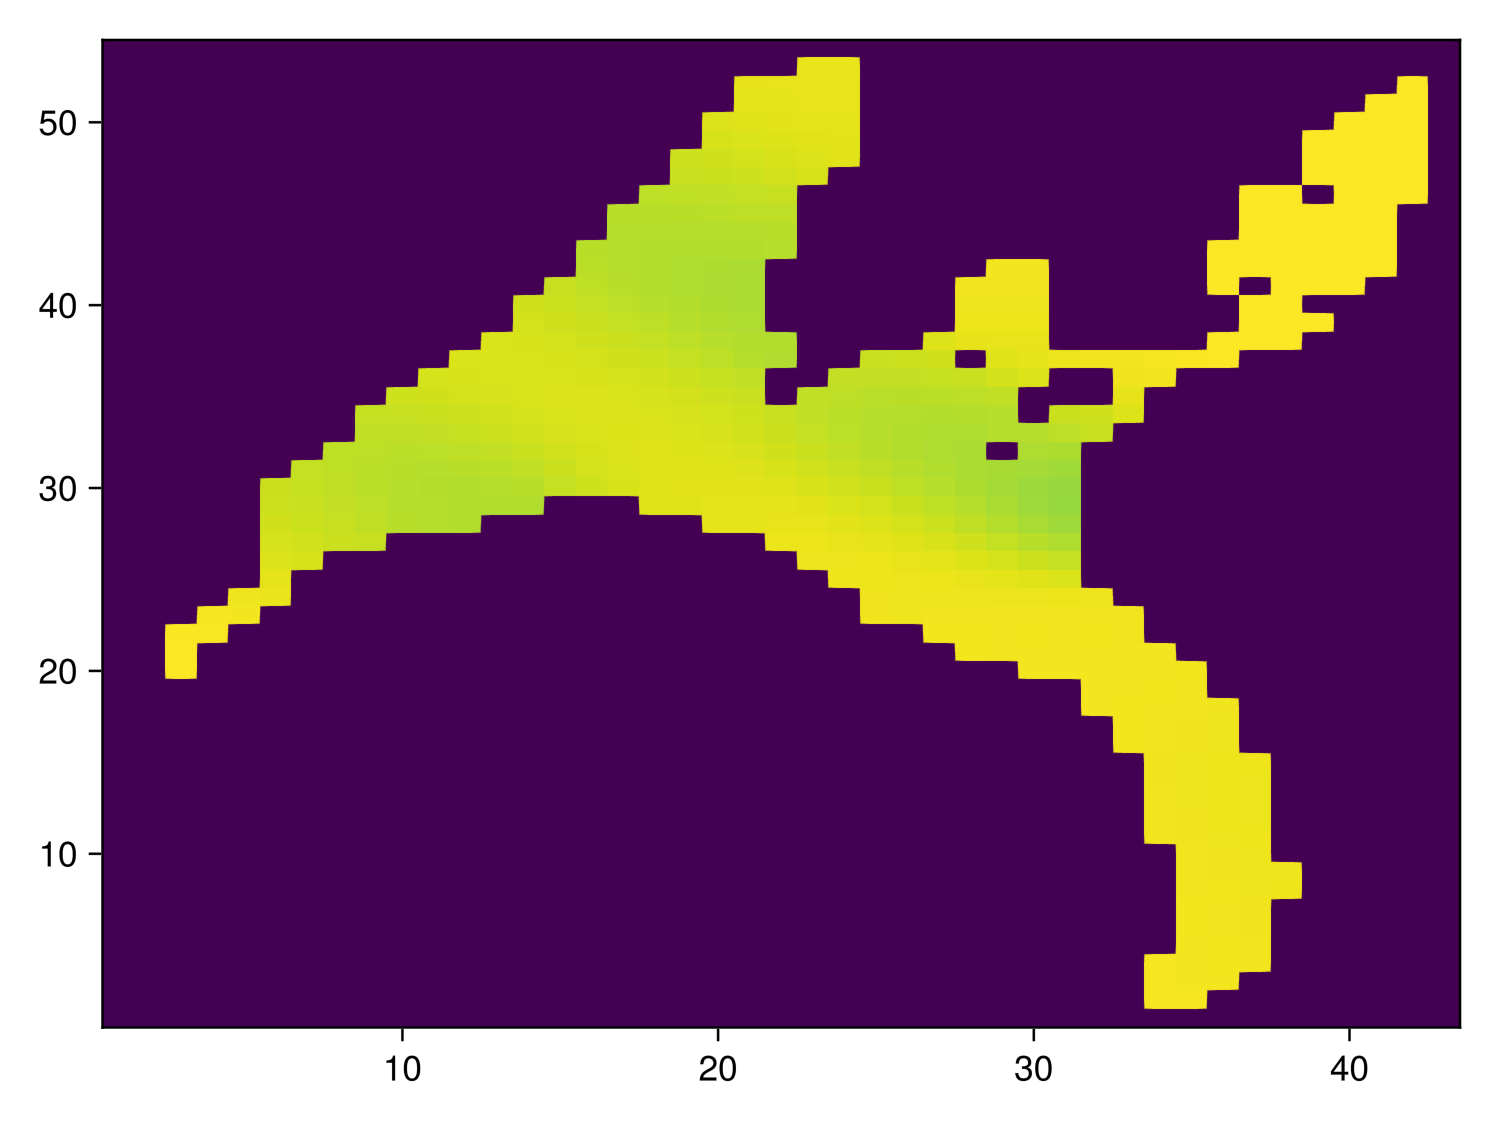

In [268]:
heatmap(interior(model.tracers.T, :, :, grid.Nz))

In [282]:
# Record a video
#
# (1) Zonal velocity (u)
# (2) Meridional velocity (v)
# (3) Temperature (T)
# (4) Salinity (S)
u_series = FieldTimeSeries("test2_snapshots.jld2", "u")
v_series = FieldTimeSeries("test2_snapshots.jld2", "v")
T_series = FieldTimeSeries("test2_snapshots.jld2", "T")

43×54×18×37 FieldTimeSeries{InMemory} located at (Center, Center, Center) of T at test2_snapshots.jld2
├── grid: 43×54×18 ImmersedBoundaryGrid{Float64, Bounded, Bounded, Bounded} on CPU with 7×7×7 halo
├── indices: (:, :, :)
├── time_indexing: Linear()
├── backend: InMemory()
├── path: test2_snapshots.jld2
├── name: T
└── data: 57×68×32×37 OffsetArray(::Array{Float64, 4}, -6:50, -6:61, -6:25, 1:37) with eltype Float64 with indices -6:50×-6:61×-6:25×1:37
    └── max=12.5, min=0.0, mean=0.590545

In [283]:
fig = Figure()
ax  = Axis(fig[1, 1], title = "temperature ᵒC")
hm = heatmap(interior(T_series[1], :, 30, :), colormap = :Spectral)
Colorbar(fig[1, 1][1, 2], hm, ticks = 1:1:12)

LoadError: MethodError: no method matching initialize_block!(::Colorbar, ::Makie.FigureAxisPlot)

[0mClosest candidates are:
[0m  initialize_block!(::Colorbar)
[0m[90m   @[39m [32mMakie[39m [90mC:\Users\ABE\.julia\packages\Makie\VRavR\src\makielayout\blocks\[39m[90m[4mcolorbar.jl:123[24m[39m


In [274]:
iter = Observable(1)

u = @lift begin
    f = interior(u_series[$iter], :, :, 18)
    f[f .== 0] .= NaN
    f
end
T = @lift begin
    f = interior(T_series[$iter], :, :, 18)
    f[f .== 0] .= NaN
    f
end
usec = @lift begin
    f = interior(u_series[$iter], :, 30, :)
    f[f .== 0] .= NaN
    f
end
Tsec = @lift begin
    f = interior(T_series[$iter], :, 30, :)
    f[f .== 0] .= NaN
    f
end

fig = Figure()

ax  = Axis(fig[1, 1], title = "surface zonal velocity ms⁻¹")
hm = heatmap!(u, colormap = :lipari)
Colorbar(fig[1, 1][1, 2], hm, ticks = 4:-0.5:-4)

ax  = Axis(fig[1, 2], title = "zonal velocity ms⁻¹")
hm = heatmap!(usec, colormap = :lipari)
Colorbar(fig[1, 2][1, 2], hm, ticks = 4:-0.5:-4)

ax  = Axis(fig[2, 1], title = "surface temperature ᵒC")
hm = heatmap!(T, colormap = :Spectral)
Colorbar(fig[2, 1][1, 2], hm, ticks = 10:0.5:12)

ax  = Axis(fig[2, 2], title = "temperature ᵒC")
hm = heatmap!(Tsec, colormap = :Spectral)
Colorbar(fig[2, 2][1, 2], hm, ticks = 0:1:12)

GLMakie.record(fig, "Tyr-sec_video.mp4", 1:length(u_series.times); framerate = 5) do i
    @info "recording iteration $i"
    iter[] = i    
end

[ Info: recording iteration 1
[ Info: recording iteration 2
[ Info: recording iteration 3
[ Info: recording iteration 4
[ Info: recording iteration 5
[ Info: recording iteration 6
[ Info: recording iteration 7
[ Info: recording iteration 8
[ Info: recording iteration 9
[ Info: recording iteration 10
[ Info: recording iteration 11
[ Info: recording iteration 12
[ Info: recording iteration 13
[ Info: recording iteration 14
[ Info: recording iteration 15
[ Info: recording iteration 16
[ Info: recording iteration 17
[ Info: recording iteration 18
[ Info: recording iteration 19
[ Info: recording iteration 20
[ Info: recording iteration 21
[ Info: recording iteration 22
[ Info: recording iteration 23
[ Info: recording iteration 24
[ Info: recording iteration 25
[ Info: recording iteration 26
[ Info: recording iteration 27
[ Info: recording iteration 28
[ Info: recording iteration 29
[ Info: recording iteration 30
[ Info: recording iteration 31
[ Info: recording iteration 32
[ Info: recording

"Tyr-sec_video.mp4"

In [113]:
output = load("test_snapshots.jld2")

Dict{String, Any} with 290 entries:
  "timeseries/v/4950"       => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0…
  "timeseries/T/4800"       => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0…
  "timeseries/u/1650"       => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0…
  "timeseries/t/1500"       => 3000.0
  "timeseries/S/4200"       => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0…
  "timeseries/t/4800"       => 9600.0
  "timeseries/v/2250"       => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0…
  "timeseries/u/serialized… => (Colon(), Colon(), Colon())
  "timeseries/w/2850"       => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0…
  "timeseries/T/4650"       => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0…
  "timeseries/t/5400"       => 10800.0
  "timeseries/T/3600"       => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0…
  "timeseries/S/300"        => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0…
  "grid/underlying_grid/Δx… => [0.0, 235.569, 235.54, 235.511

In [118]:
output["timeseries/T/4800"]

93×110×43 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.

In [115]:
keys(output)

KeySet for a Dict{String, Any} with 290 entries. Keys:
  "timeseries/v/4950"
  "timeseries/T/4800"
  "timeseries/u/1650"
  "timeseries/t/1500"
  "timeseries/S/4200"
  "timeseries/t/4800"
  "timeseries/v/2250"
  "timeseries/u/serialized/indices"
  "timeseries/w/2850"
  "timeseries/T/4650"
  "timeseries/t/5400"
  "timeseries/T/3600"
  "timeseries/S/300"
  "grid/underlying_grid/Δxᶠᶠᵃ"
  "timeseries/S/4350"
  "timeseries/t/2700"
  "timeseries/t/3000"
  "timeseries/T/2850"
  "timeseries/u/2700"
  "timeseries/u/2100"
  "timeseries/T/serialized/boundary_conditions"
  "timeseries/v/2700"
  "timeseries/u/1050"
  "timeseries/T/150"
  "timeseries/t/1050"
  ⋮

In [ ]:
close(output)

In [25]:
?ConvectiveAdjustmentVerticalDiffusivity

search: ConvectiveAdjustmentVerticalDiffusivity



```
ConvectiveAdjustmentVerticalDiffusivity([time_discretization = VerticallyImplicitTimeDiscretization(), FT=Float64;]
                                        convective_κz = 0,
                                        convective_νz = 0,
                                        background_κz = 0,
                                        background_νz = 0)
```

Return a convective adjustment vertical diffusivity closure that applies different values of diffusivity and/or viscosity depending whether the region is statically stable (positive or zero buoyancy gradient) or statically unstable (negative buoyancy gradient).

# Arguments

  * `time_discretization`: Either `ExplicitTimeDiscretization()` or `VerticallyImplicitTimeDiscretization()`;                        default `VerticallyImplicitTimeDiscretization()`.
  * `FT`: Float type; default `Float64`.

# Keyword arguments

  * `convective_κz`: Vertical tracer diffusivity in regions with negative (unstable) buoyancy gradients. Either                  a single number, function, array, field, or tuple of diffusivities for each tracer.
  * `background_κz`: Vertical tracer diffusivity in regions with zero or positive (stable) buoyancy gradients.
  * `convective_νz`: Vertical viscosity in regions with negative (unstable) buoyancy gradients. Either                 a number, function, array, or field.
  * `background_κz`: Vertical viscosity in regions with zero or positive (stable) buoyancy gradients.

# Example

```jldoctest
julia> using Oceananigans

julia> cavd = ConvectiveAdjustmentVerticalDiffusivity(convective_κz = 1)
ConvectiveAdjustmentVerticalDiffusivity{VerticallyImplicitTimeDiscretization}(background_κz=0.0 convective_κz=1 background_νz=0.0 convective_νz=0.0)
```
